In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fenics as fe

import sys
sys.path.insert(0, "../src")

from swe import ShallowOne, ShallowOneLinear
control = dict(nx=500, dt=2., theta=0.6, simulation="tidal_flow")

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


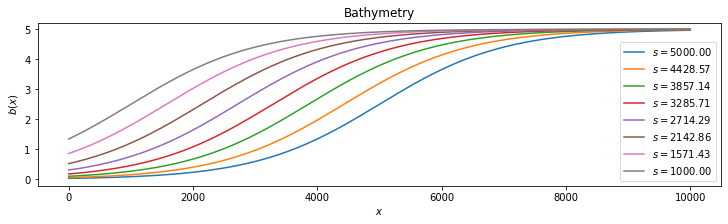

In [2]:
# set up bump/dissipation args
shore_starts = np.linspace(1000., 5000., num=8)
nus = np.linspace(1., 10_000., num=8)

shore_model_args = [
    (shore_start, 1., False) for shore_start in shore_starts]
shore_linear_model_args = [
    (shore_start, 1., True) for shore_start in shore_starts]
damped_model_args = [(1000., nu, False) for nu in nus]

# now plot the different bathymetries
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 3))
for s in shore_starts[::-1]:
    swe = ShallowOne(control=control, 
                     params=dict(nu=1.,
                                 shore_start=s, shore_height=2.5,
                                 bump_height=0., bump_centre=1000., bump_width=400))
    fe.plot(30 - swe.H, label=fr"$s = {s:.2f}$")
    
ax.set_title("Bathymetry")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$b(x)$")
ax.legend()
plt.show()

In [32]:
fe.set_log_level(50)

def run_model(shore_start, nu, linear):
    if linear:
        swe = ShallowOneLinear(control=control,
                               params=dict(nu=nu,
                                           shore_start=shore_start, shore_height=2.5,
                                           bump_height=0., bump_centre=1000., bump_width=400))
    else:
        swe = ShallowOne(control=control, 
                         params=dict(nu=nu,
                                     shore_start=shore_start, shore_height=2.5,
                                     bump_height=0., bump_centre=1000., bump_width=400))
        
    t_final = 60 * 60 * 12.
    nt = int((t_final) / swe.dt)

    i_save = 0
    nt_skip = 5  # store every 10 s
    nt_save = len([i for i in range(nt) if i % nt_skip == 0])

    t_out = np.zeros((nt_save, ))
    u_out = np.zeros((nt_save, len(swe.mesh.coordinates())))
    h_out = np.zeros((nt_save, len(swe.mesh.coordinates())))

    t = 0.
    from tqdm import tqdm
    for i in tqdm(range(nt)):
        t += swe.dt
        swe.solve(t)

        if i % nt_skip == 0:
            t_out[i_save] = t
            u, h = swe.du.split()
            u_out[i_save, :] = u.compute_vertex_values()
            h_out[i_save, :] = h.compute_vertex_values()

            i_save += 1
    
    return [t_out, u_out, h_out]

In [33]:
ref_model = run_model(2000., 1., False)

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 16962/21600 [01:20<00:22, 209.50it/s]


KeyboardInterrupt: 

In [11]:
from multiprocessing import Pool

p = Pool()
out_shore = p.starmap_async(run_model, shore_model_args)
out_linear_shore = p.starmap_async(run_model, shore_model_args)
out_damped = p.starmap(run_model, damped_model_args)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21600/21600 [02:08<00:00, 168.67it/s]
Process ForkPoolWorker-35:
Process ForkPoolWorker-41:
Process ForkPoolWorker-33:
Process ForkPoolWorker-36:
Process ForkPoolWorker-44:
Process ForkPoolWorker-45:
Process ForkPoolWorker-38:
Process ForkPoolWorker-47:
Process ForkPoolWorker-37:
Process ForkPoolWorker-48:
Process ForkPoolWorker-43:
Process ForkPoolWorker-39:
Process ForkPoolWorker-42:
Process ForkPoolWorker-40:
Process ForkPoolWorker-34:
Process ForkPoolWorker-53:
Process ForkPoolWorker-46:
Process ForkPoolWorker-50:
Process ForkPoolWorker-54:
Process ForkPoolWorker-61:
Process ForkPoolWorker-52:
Process ForkPoolWorker-63:
Process ForkPoolWorker-56:
Process ForkPoolWorker-59:
Process ForkPoolWorker-62:
Process ForkPoolWorker-60:
Process ForkPoolWorker-58:
Process ForkPoolWorker-49:
Process ForkPoolWorker-55:
Process ForkPoolWorker-51:
Process ForkPoolW

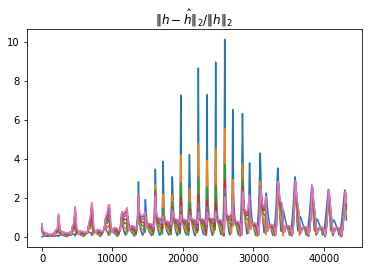

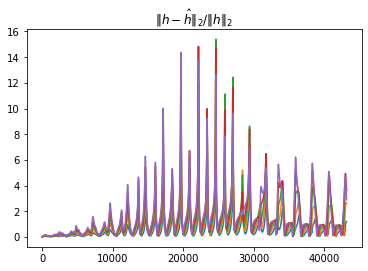

In [16]:
norm = np.linalg.norm
t_out = out_damped[0][0]

for i in range(len(damped_model_args) - 1):
    plt.plot(t_out, 
             norm(ref_model[2] - out_damped[i][2], axis=1) / norm(ref_model[2], axis=1))
    
plt.title(r"$\Vert h - \hat{h} \Vert_2 / \Vert h \Vert_2$")
plt.show()

for model in out_shore.get()[3:]:
    plt.plot(t_out, 
             norm(ref_model[2] - model[2], axis=1) / norm(ref_model[2], axis=1))
    
plt.title(r"$\Vert h - \hat{h} \Vert_2 / \Vert h \Vert_2$")
plt.show()